# Constructing a NEP polarizability model
## Introduction

In this tutorial, we will show you how to use the ``GPUMD`` package to train a NEP polarizability model and analyze the results.
For theoretical background on the NEP approach, please read the [documentation](https://gpumd.org/potentials/nep). A paper that introduces the NEP polarizability model systematically is in preparation. 


## Prerequisites
You need to have access to an NVIDIA GPU with compute capability >= 3.5. Besides it, CUDA Toolkit 9.0 or higher is needed to compile the GPUMD package.
The latest GPUMD (we recommend v3.7 or newer) can be downloaded [here](https://github.com/brucefan1983/GPUMD/releases). Unpack it, go to the ``src`` directory, and run the command ``make -j`` to compile. If success, you should get two executables: ``gpumd`` and ``nep`` in the ``src`` directory. The flag "-std=c++14" in makefile can be modified to "-std=c++11" if you failed the compilation process.

## Train a NEP polarizability model for QM7B database
To train a NEP polarizability model, two files: ``train.xyz`` and ``nep.in`` are mandatory. The ``train.xyz`` file contains necessary training data, and the `nep.in` file contains some parameters used for training. Optionally, one can also provide a ``test.xyz`` file that has similar contents as the``train.xyz`` for validation.

### Prepare the train.xyz and test.xyz files
- The ``train.xyz``/``test.xyz`` file should be prepared according to the [documentation](https://gpumd.org/nep/input_files/).
- In this tutorial, ``train.xyz`` and ``test.xyz`` files are already prepared in the current folder, which contain 5768 and 1443 structures, respectively. Structures as well as polarizability data in the ``train.xyz`` and ``test.xyz`` are taken from the [QM7B database](https://archive.materialscloud.org/record/2019.0002/v2) that contains 7211 organic compounds. The (static) polarizability is a symmetric second-order tensor that has a form of 
$$\boldsymbol{\alpha }=\left( \begin{matrix}
	\alpha _{xx}&		\alpha _{xy}&		\alpha _{xz}\\
	\alpha _{yx}&		\alpha _{yy}&		\alpha _{yz}\\
	\alpha _{zx}&		\alpha _{zy}&		\alpha _{zz}\\
\end{matrix} \right) $$
The polarizability data are embedded in the comment lines of ``train.xyz``/``test.xyz``, organized as *pol="	$\alpha _{xx}$  $\alpha _{xy} $  $\alpha _{xz}$	$\alpha _{yx}$  $\alpha _{yy} $  $\alpha _{yz}$ 	$\alpha _{zx}$  $\alpha _{zy} $  $\alpha _{zz}$"* per structure. The polarizability data were computed at the CCSD/d-aug-cc-pVDZ level of theory by [Yang and collaborators](https://www.nature.com/articles/s41597-019-0157-8). Of course, you can use any quantum mechanics package and any theoretical method such as the DFT to calculate the polarizability. However, structures in [QM7B database](https://archive.materialscloud.org/record/2019.0002/v2) are without lattice information, which is mandatory in the training of NEP models. Therefore, a cubic box with a dimension of 100 $\rm \mathring{A}$ was set for every structure. We recommend the [ASE package](https://wiki.fysik.dtu.dk/ase/) to manipulate the ``train.xyz``/``test.xyz`` file.   

### Prepare the `nep.in` file. 
- First, read the [documentation](https://gpumd.org/nep/input_files/) regarding input paramaters carefully. The most important parameter is `mode`, which controls the training types. `mode=0` which is default, stands for a training task of PES;`mode=1`, a training task of dipole; `mode=2`, a training task of polarizability. Here, we set `mode=2`.     
A minimal ``nep.in`` file reads:
```
type        6 H C N O S Cl	
mode        2
```
The parameter `type` is also important, which specified the element kinds in the system. The first value `6` is the number of elements in ``train.xyz``/``test.xyz``, followed by the detailed element names, in this case, `H C N O S Cl`. **The order will be frozen in the model after training.** We have prepared the ``nep.in`` file in the current folder, which reads:
```
type         6 H C N O S Cl	
mode         2
cutoff       6 4
n_max        6 6
basis_size    10 10
l_max        4 2 1
neuron       10
population    80
batch        10000
generation   200000
lambda_1     0.03
lambda_2     0.03
```

The values of parameters `cutoff`, `n_max`,`basis_size`,`l_max`, `neuron`,`population` used here were tested elaborately, which achieved a good balance between the accuracy and costs. The batch size depends on your GPU device. On a GeForce RTX 3090 with 24 GB memory, you can train the model with all data at the same time, therefore, we set `batch ` a value greater than 5768. The `lambda_1` and `lambda_1` are the [regularization paramaters](https://gpumd.org/nep/input_parameters/lambda_1.html). You can **take the default values trustingly just ignore these two parameters.** The `GPUMD` will adjust these two parameters dynamically according to the real-time loss. Alternatively, you can set  lambda_1 and lambda_2 a fixed value which should be of the [same order as the target quantities]((https://gpumd.org/nep/input_parameters/lambda_1.html)) upon convergence. In this example, we set `lambda_1=lambda_2=0.03`.We will look back on it after analyzing the results.
 
 

### Run the ``nep`` executable
 - Run the following command in the working directory
```
path/to/nep # if you use linux
path\to\nep # if you use Windows
```
 
It took about 22 hours to run 200,000 generations using a GeForce RTX 3090. One can kill the task at any time and also restart it just by running the `nep` again.

## Check the training results

- After you launch the `nep` task, there should be some output on the screen. We encourage the user to read the screen output carefully. It can help to understand the working flow of `nep`. 
- Some files will be generated in the current folder and will be updated every 100 generations (some will be updated every 1000 generations). Therefore, one can check the results even before finishing the maximum number of generations as set in `nep.in`. 
- If the user has not read the documentation regarding the output files, it is time to read about those [here](https://gpumd.org/nep/output_files/).
- We will use Python to visualize the results in some of the output files next. We first load ``pylab`` that we need.

In [2]:
from pylab import *

### Checking the ``loss.out`` file
- We see that the $\mathcal{L}_1$ and $\mathcal{L}_2$ regularization loss functions first increases and then decreases, which indicates the effectiveness of the regularization.
- The polarizability loss is the root mean square error (RMSE) of polarizability per atom, which converges to about 0.03-0.04 a.u./atom.

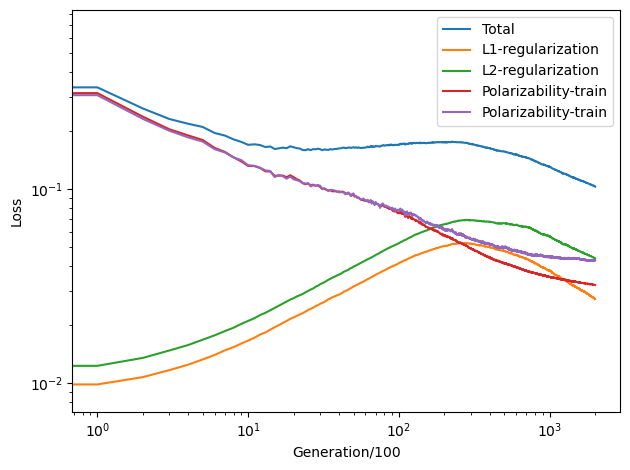

In [3]:
loss = loadtxt('loss.out')
loglog(loss[:, 1:4])
loglog(loss[:, 4:6])
xlabel('Generation/100')
ylabel('Loss')
legend(['Total', 'L1-regularization', 'L2-regularization', 'Polarizability-train', 'Polarizability-train'])
tight_layout()

The loss terms 'Polarizability-train' and 'Polarizability-train' converged after 20,000 generations (But you can run it longer). That's why we choose the paramaters `lambda_1=lambda_2=0.03`. But you can **take the default values trustingly**.

### Checking the `polarizability_test.out` file

The `polarizability_test.out` is organized as "$\alpha _{xx}$  $\alpha _{yy} $  $\alpha _{zz}$	 $\alpha _{xy}$  $\alpha _{yz} $  $\alpha _{xz}$ $\alpha _{xx}$  $\alpha _{yy} $  $\alpha _{zz}$	 $\alpha _{xy}$  $\alpha _{yz} $  $\alpha _{xz}$", one line per structure. The first six values are predicted by `NEP`, while the last six values are the references we provide in `test.xyz`(but divided by the number of atoms).

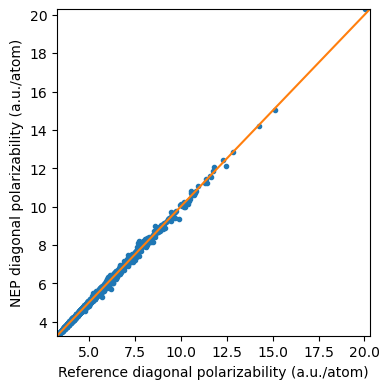

In [6]:
# for diagonal elements
pol_diag_test = loadtxt('polarizability_test.out',usecols=(0,1,2,6,7,8))
ref_values = np.hstack([pol_diag_test[:,3],pol_diag_test[:,4],pol_diag_test[:,5]])
nep_values = np.hstack([pol_diag_test[:,0],pol_diag_test[:,1],pol_diag_test[:,2]])
plot(ref_values,nep_values , '.')
plot(linspace(pol_diag_test.min(),pol_diag_test.max()), linspace(pol_diag_test.min(),pol_diag_test.max()), '-')
xlim((pol_diag_test.min(),pol_diag_test.max()))
ylim((pol_diag_test.min(),pol_diag_test.max()))
xlabel('Reference diagonal polarizability (a.u./atom)')
ylabel('NEP diagonal polarizability (a.u./atom)')
fig = plt.gcf()
fig.set_size_inches(4,4)
tight_layout()

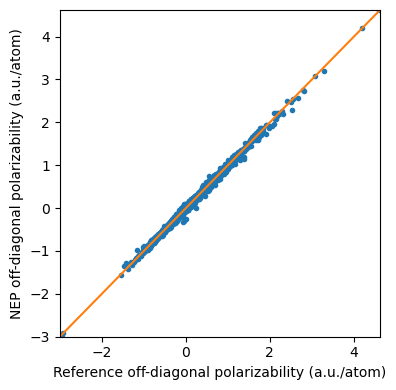

In [7]:
# for off-diagonal elements
pol_offdiag_test = loadtxt('polarizability_test.out',usecols=(3,4,5,9,10,11))
ref_values = np.hstack([pol_offdiag_test[:,3],pol_offdiag_test[:,4],pol_offdiag_test[:,5]])
nep_values = np.hstack([pol_offdiag_test[:,0],pol_offdiag_test[:,1],pol_offdiag_test[:,2]])
plot(ref_values,nep_values , '.')
plot(linspace(pol_offdiag_test.min(),pol_offdiag_test.max()), linspace(pol_offdiag_test.min(),pol_offdiag_test.max()), '-')
xlim((pol_offdiag_test.min(),pol_offdiag_test.max()))
ylim((pol_offdiag_test.min(),pol_offdiag_test.max()))
xlabel('Reference off-diagonal polarizability (a.u./atom)')
ylabel('NEP off-diagonal polarizability (a.u./atom)')
fig = plt.gcf()
fig.set_size_inches(4,4)
tight_layout()

### Get molecular polarizability

Numbers of atoms are varied for different structures in the QM7B database. To get their polarizability, we should know their numbers of atoms. The following `Python` script can be used to obtain the molecular polarizability for each structure in `test.xyz`.

In [16]:
import os
file_size = os.path.getsize("test.xyz")
noa_list = []
with open("test.xyz") as reader:
    while (reader.tell() < file_size):
        noa = int(reader.readline())
        noa_list.append(noa)
        for i in range(noa+1):
            reader.readline()

atomic_pol_diag_test = loadtxt('polarizability_test.out',usecols=(0,1,2,6,7,8))
            
molecular_diagonal_polarizability = atomic_pol_diag_test * np.tile(np.array(noa_list).reshape(-1,1),(1,6))
print("Diagonal elements:")
print(molecular_diagonal_polarizability)

atomic_pol_offdiag_test = loadtxt('polarizability_test.out',usecols=(3,4,5,9,10,11))
            
molecular_offdiag_polarizability = atomic_pol_offdiag_test * np.tile(np.array(noa_list).reshape(-1,1),(1,6))
print("Off-diagonal elements:")
print(molecular_offdiag_polarizability)
        

Diagonal elements:
[[ 86.93239  81.89478  64.59779  86.77072  81.95972  63.94601]
 [ 66.87154  75.06843  70.12993  67.42251  75.463    70.00906]
 [ 95.30625  72.51928  69.21652  95.10905  72.87611  68.8432 ]
 ...
 [ 65.3233   67.70946  55.286    65.57978  67.49064  55.38372]
 [ 78.4861  118.855    47.02907  77.48224 119.3984   47.36193]
 [ 68.6895   70.45695  68.69175  68.29755  70.4676   68.9577 ]]
Off-diagonal elements:
[[-2.1363730e+00 -2.0750540e+00  7.9340360e+00 -1.8626050e+00
  -1.8792140e+00  7.2918270e+00]
 [ 1.8631660e+00  1.6867077e+00  8.0070000e-01  2.1008430e+00
   1.8908760e+00  6.6708000e-01]
 [ 1.4109745e+01  3.6405840e+00  1.7375190e+00  1.4100157e+01
   3.8441590e+00  1.6899003e+00]
 ...
 [ 6.9831720e-01 -1.1632208e+00  6.2205360e+00  9.8580300e-01
  -9.8249060e-01  6.4980860e+00]
 [ 3.3778140e+01 -6.1842220e-02  2.8229300e-02  3.3851840e+01
  -8.4909000e-02  2.3642960e-02]
 [-1.2690855e-01  9.5440650e-02 -8.6488950e+00 -1.1436195e-01
   9.4393050e-02 -8.2682400e+00]

## Prediction
- You can switch the workding mode from training to prediction by adding an extra parameter `prediction 1` in `nep.in`, and provide a `train.xyz`. In this mode, the polarizability data is not necessary in `train.xyz`. The `NEP` will use `-1e+06` as the reference values in `polarizability_train.out`. We also provide an example in the `prediction_new_molecule` directory.  

## Restart
- After each 100 steps, the ``nep.restart`` file will be updated.
- If ``nep.restart`` exists, it means you want to continue the previous training. Remember not to change the parameters related to the descriptor and the number of neurons. Otherwise the restarting behavior is undefined.
- If you want to train from scratch, you need to delete ``nep.restart`` first (better to first make a copy of all the results from the previous training).

## Author 

Nan Xu 

tamas@zju.edu.cn